In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime
os.chdir('/users/marianne/documents/ICB')

In [30]:
hobo = pd.read_csv('hoboA1.csv',header=1)
hobo['dt']=pd.to_datetime(hobo[kh[1]])
kh = hobo.keys()
station = pd.read_csv('TableA1.csv',header=0)
station['dt'] = pd.to_datetime(station['TIMESTAMP'])
ks = station.keys()
station_wy20 = station[station['dt']>hobo['dt'][0]]

/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'temp')

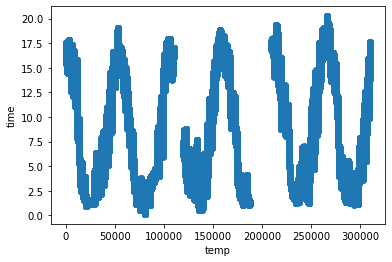

In [35]:
f,ax=plt.subplots()
ax.plot(station['T_Avg'],'o')
ax.set_ylabel('time')
ax.set_xlabel('temp')

Text(0.5, 0, 'intensity')

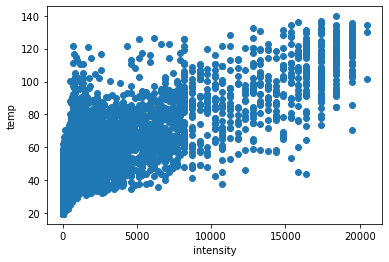

In [33]:
f,ax=plt.subplots()
ax.plot(hobo[kh[3]],hobo[kh[2]],'o')
ax.set_ylabel('temp')
ax.set_xlabel('intensity')

In [60]:
station_wy20['dt']

276247   2020-10-29 09:10:00
276248   2020-10-29 09:20:00
276249   2020-10-29 09:30:00
276250   2020-10-29 09:40:00
276251   2020-10-29 09:50:00
                 ...        
309962   2021-06-20 12:20:00
309963   2021-06-20 12:30:00
309964   2021-06-20 12:40:00
309965   2021-06-20 12:50:00
309966   2021-06-20 13:00:00
Name: dt, Length: 33720, dtype: datetime64[ns]

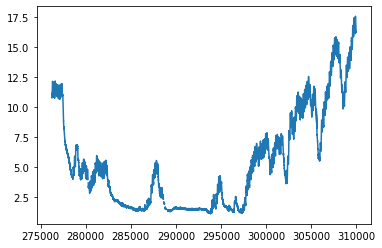

In [59]:
plt.plot(station_wy20['T_Avg'].astype('float'))

In [61]:
series=pd.Series(station_wy20['T_Avg'].astype('float'),index=station_wy20['dt'])

In [66]:
series.resample('15T').bfill()

dt
2020-10-29 09:00:00   NaN
2020-10-29 09:15:00   NaN
2020-10-29 09:30:00   NaN
2020-10-29 09:45:00   NaN
2020-10-29 10:00:00   NaN
                       ..
2021-06-20 12:00:00   NaN
2021-06-20 12:15:00   NaN
2021-06-20 12:30:00   NaN
2021-06-20 12:45:00   NaN
2021-06-20 13:00:00   NaN
Freq: 15T, Name: T_Avg, Length: 22481, dtype: float64

In [99]:
station_wy20['T_Avg'].resample('20T').bfill()

dt
2020-10-29 09:00:00    11.15
2020-10-29 09:20:00    11.15
2020-10-29 09:40:00     11.1
2020-10-29 10:00:00    11.07
2020-10-29 10:20:00    11.03
                       ...  
2021-06-20 11:40:00    16.27
2021-06-20 12:00:00    16.24
2021-06-20 12:20:00    16.24
2021-06-20 12:40:00    16.31
2021-06-20 13:00:00    16.24
Freq: 20T, Name: T_Avg, Length: 16861, dtype: object

In [102]:
station_hourly = station_wy20['T_Avg'].resample('60T').bfill()
hobo_hourly = hobo[kh[2]].resample('60T').bfill()

In [118]:
station_hourly

dt
2020-10-29 09:00:00    11.15
2020-10-29 10:00:00    11.07
2020-10-29 11:00:00    10.96
2020-10-29 12:00:00    10.83
2020-10-29 13:00:00     10.8
                       ...  
2021-06-20 09:00:00    16.51
2021-06-20 10:00:00    16.38
2021-06-20 11:00:00    16.29
2021-06-20 12:00:00    16.24
2021-06-20 13:00:00    16.24
Freq: 60T, Name: T_Avg, Length: 5621, dtype: object

In [131]:
hourly_temps = pd.DataFrame(hobo_hourly).join(pd.DataFrame(station_hourly))
hourly_temps.columns=['hobo','station']


In [144]:
hourly_temps['hobo c'] = (hourly_temps['hobo'] - 32) / 1.8  
hourly_temps['difference'] = hourly_temps['station'].astype('float')-hourly_temps['hobo c']

TypeError: unsupported operand type(s) for -: 'str' and 'float'

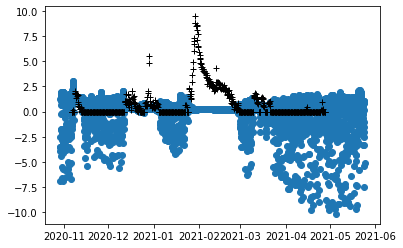

In [173]:
f,ax=plt.subplots()
ax.plot(hourly_temps['difference']/5,'o')
ax.plot(camera_wy20['Snow Depth (mm)']/100,'k+')

In [163]:
camera = pd.read_csv('snow_summary.csv',header=2)
camera['dt'] = pd.to_datetime(cameradata['Date'])
camera_wy20 = camera[camera['dt']>hobo['dt'][0]]


In [167]:
camera_wy20.index = camera_wy20['dt']

0      2015-11-02 08:00:00
1      2015-11-02 11:00:00
2      2015-11-02 14:00:00
3      2015-11-02 17:00:00
4      2015-11-03 08:00:00
               ...        
4059   2021-04-26 16:00:00
4060   2021-04-27 07:00:00
4061   2021-04-27 10:00:00
4062   2021-04-27 13:00:00
4063   2021-04-27 16:00:00
Name: dt, Length: 4064, dtype: datetime64[ns]